In [ ]:
import torch 
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import sys, os, time, optuna
import torchvision.utils as vutils
import utils as U
import architecture
import scipy.ndimage
import matplotlib.pyplot as plt
import numpy as np
import data

#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print('Device: ', device)
print('Modules Loaded :)')

/Users/sandipr/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cpu
Modules Loaded :)


In [2]:
# Set up matplotlib settings
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

plt.rcParams.update(plt.rcParamsDefault)  # Reset the default matplotlib settings

plt.rcParams['figure.figsize'] = (5, 4)  # Set the figure size (width, height) in inches

plt.rcParams['font.size'] = 12  # Set the font size for labels and titles
plt.rcParams['figure.dpi'] = 150  # Set the DPI (dots per inch) for high-resolution output
plt.rcParams['font.family'] = 'serif'  # Set the font family

plt.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the axes
plt.rcParams['axes.edgecolor'] = 'black'  # Set the color of the axes' edges
plt.rcParams['axes.spines.top'] = True  # Hide the top spine of the axes
plt.rcParams['axes.spines.right'] = True  # Hide the right spine of the axes

plt.rcParams['xtick.direction'] = 'in'  # Set the direction of x-axis ticks to inward
plt.rcParams['xtick.major.size'] = 4  # Set the size of major x-axis ticks
plt.rcParams['xtick.major.width'] = 1.2  # Set the width of major x-axis ticks
plt.rcParams['xtick.minor.size'] = 2  # Set the size of minor x-axis ticks
plt.rcParams['xtick.minor.width'] = 1.0  # Set the width of minor x-axis ticks

plt.rcParams['ytick.direction'] = 'in'  # Set the direction of y-axis ticks to inward
plt.rcParams['ytick.right'] = True  # Show the y-ticks on the right axis
plt.rcParams['ytick.major.size'] = 4  # Set the size of major y-axis ticks
plt.rcParams['ytick.major.width'] = 1.2  # Set the width of major y-axis ticks
plt.rcParams['ytick.minor.size'] = 2  # Set the size of minor y-axis ticks
plt.rcParams['ytick.minor.width'] = 1.0  # Set the width of minor y-axis ticks

plt.rcParams['lines.linewidth'] = 1.5  # Set the linewidth of the plotted lines
plt.rcParams['legend.frameon'] = False  # Hide the frame of the legend
plt.rcParams['legend.fontsize'] = 10  # Set the font size of the legend

# ... Additional settings as needed ...


## Loading in the images and playing around with them

In [3]:
raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy')
print(raw_images.shape)

(15000, 256, 256)


(1000, 6)


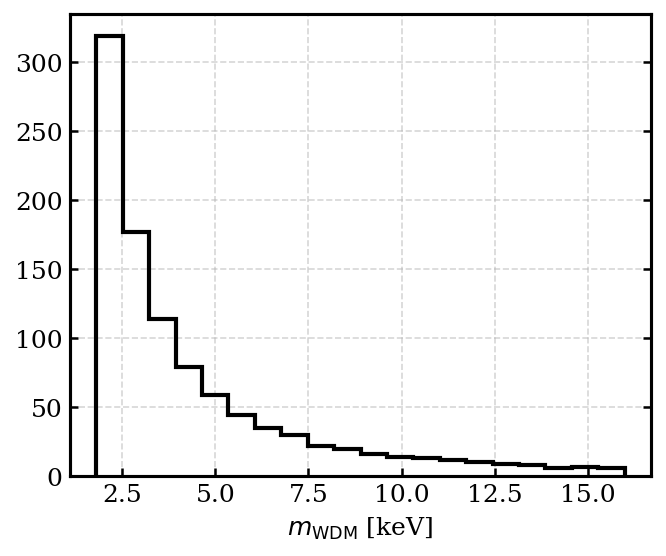

In [4]:
WDM_params = np.loadtxt('WDM_TNG_params_1000.txt')
print(WDM_params.shape)
WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
WDM_params = (WDM_params * (maximum - minimum)) + minimum

#bins = np.arange(0,30,0.5)
bins = 20
# plot a histogram of the WDM masses, log scale histogram
plt.figure(figsize=(5, 4))
plt.hist((1./WDM_params[:, 5]), bins=bins, color='k', histtype='step', lw=2, density=False, log=False)
#plt.hist((WDM_params[:, 1]), bins=bins, color='k', histtype='step', lw=2, density=False, log=False)
plt.grid(True, ls='--', alpha=0.5, which='both')
plt.xlabel(r'$m_{\rm WDM}$ [keV]')
plt.show()

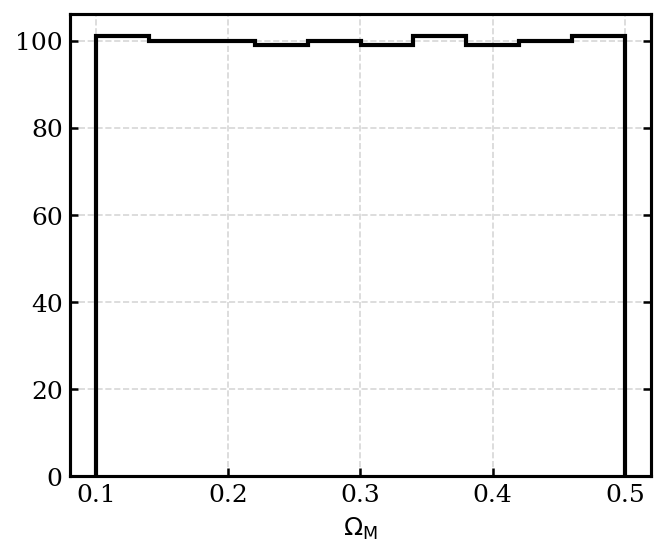

In [5]:
# histogram of the OmegaM values
plt.figure(figsize=(5, 4))
plt.hist(WDM_params[:, 0], bins=10, color='k', histtype='step', lw=2, density=False, log=False)
plt.grid(True, ls='--', alpha=0.5, which='both')
plt.xlabel(r'$\Omega_{\rm M}$')
plt.show()


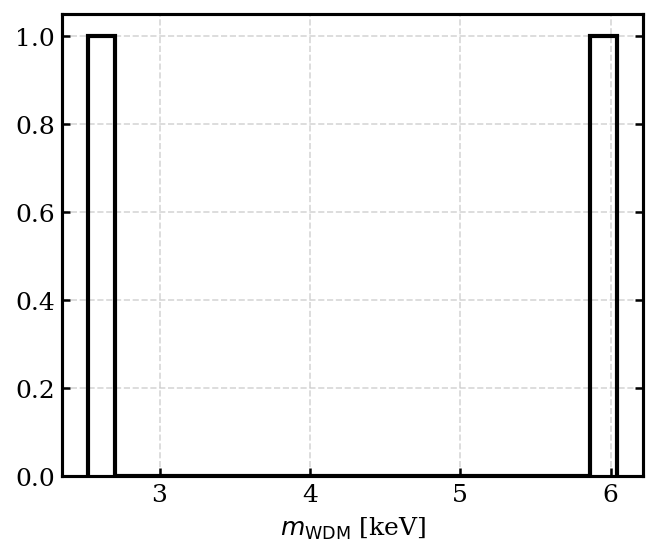

In [6]:
## Plotting a histogram of WDM masses for a set range of OmegaM and sigma8
epsilon = 0.005
OmegaM_range = [0.49-epsilon,0.49+epsilon]
sigma8_range = [0.8-4*epsilon,0.8+4*epsilon]
WDM_masses = (1./WDM_params[:, 5])[(WDM_params[:, 0] > OmegaM_range[0]) & (WDM_params[:, 0] < OmegaM_range[1]) & (WDM_params[:, 1] > sigma8_range[0]) & (WDM_params[:, 1] < sigma8_range[1])]

plt.figure(figsize=(5, 4))
plt.hist(WDM_masses, bins=bins, color='k', histtype='step', lw=2, density=False, log=False)
plt.grid(True, ls='--', alpha=0.5, which='both')
plt.xlabel(r'$m_{\rm WDM}$ [keV]')
plt.show()

415
Params: [0.485358   0.815636   2.914225   0.995822   3.9307     0.16552468]
WDM mass: 6.041395338791633 keV, OmegaM: 0.48535800000000007, Sigma8: 0.815636


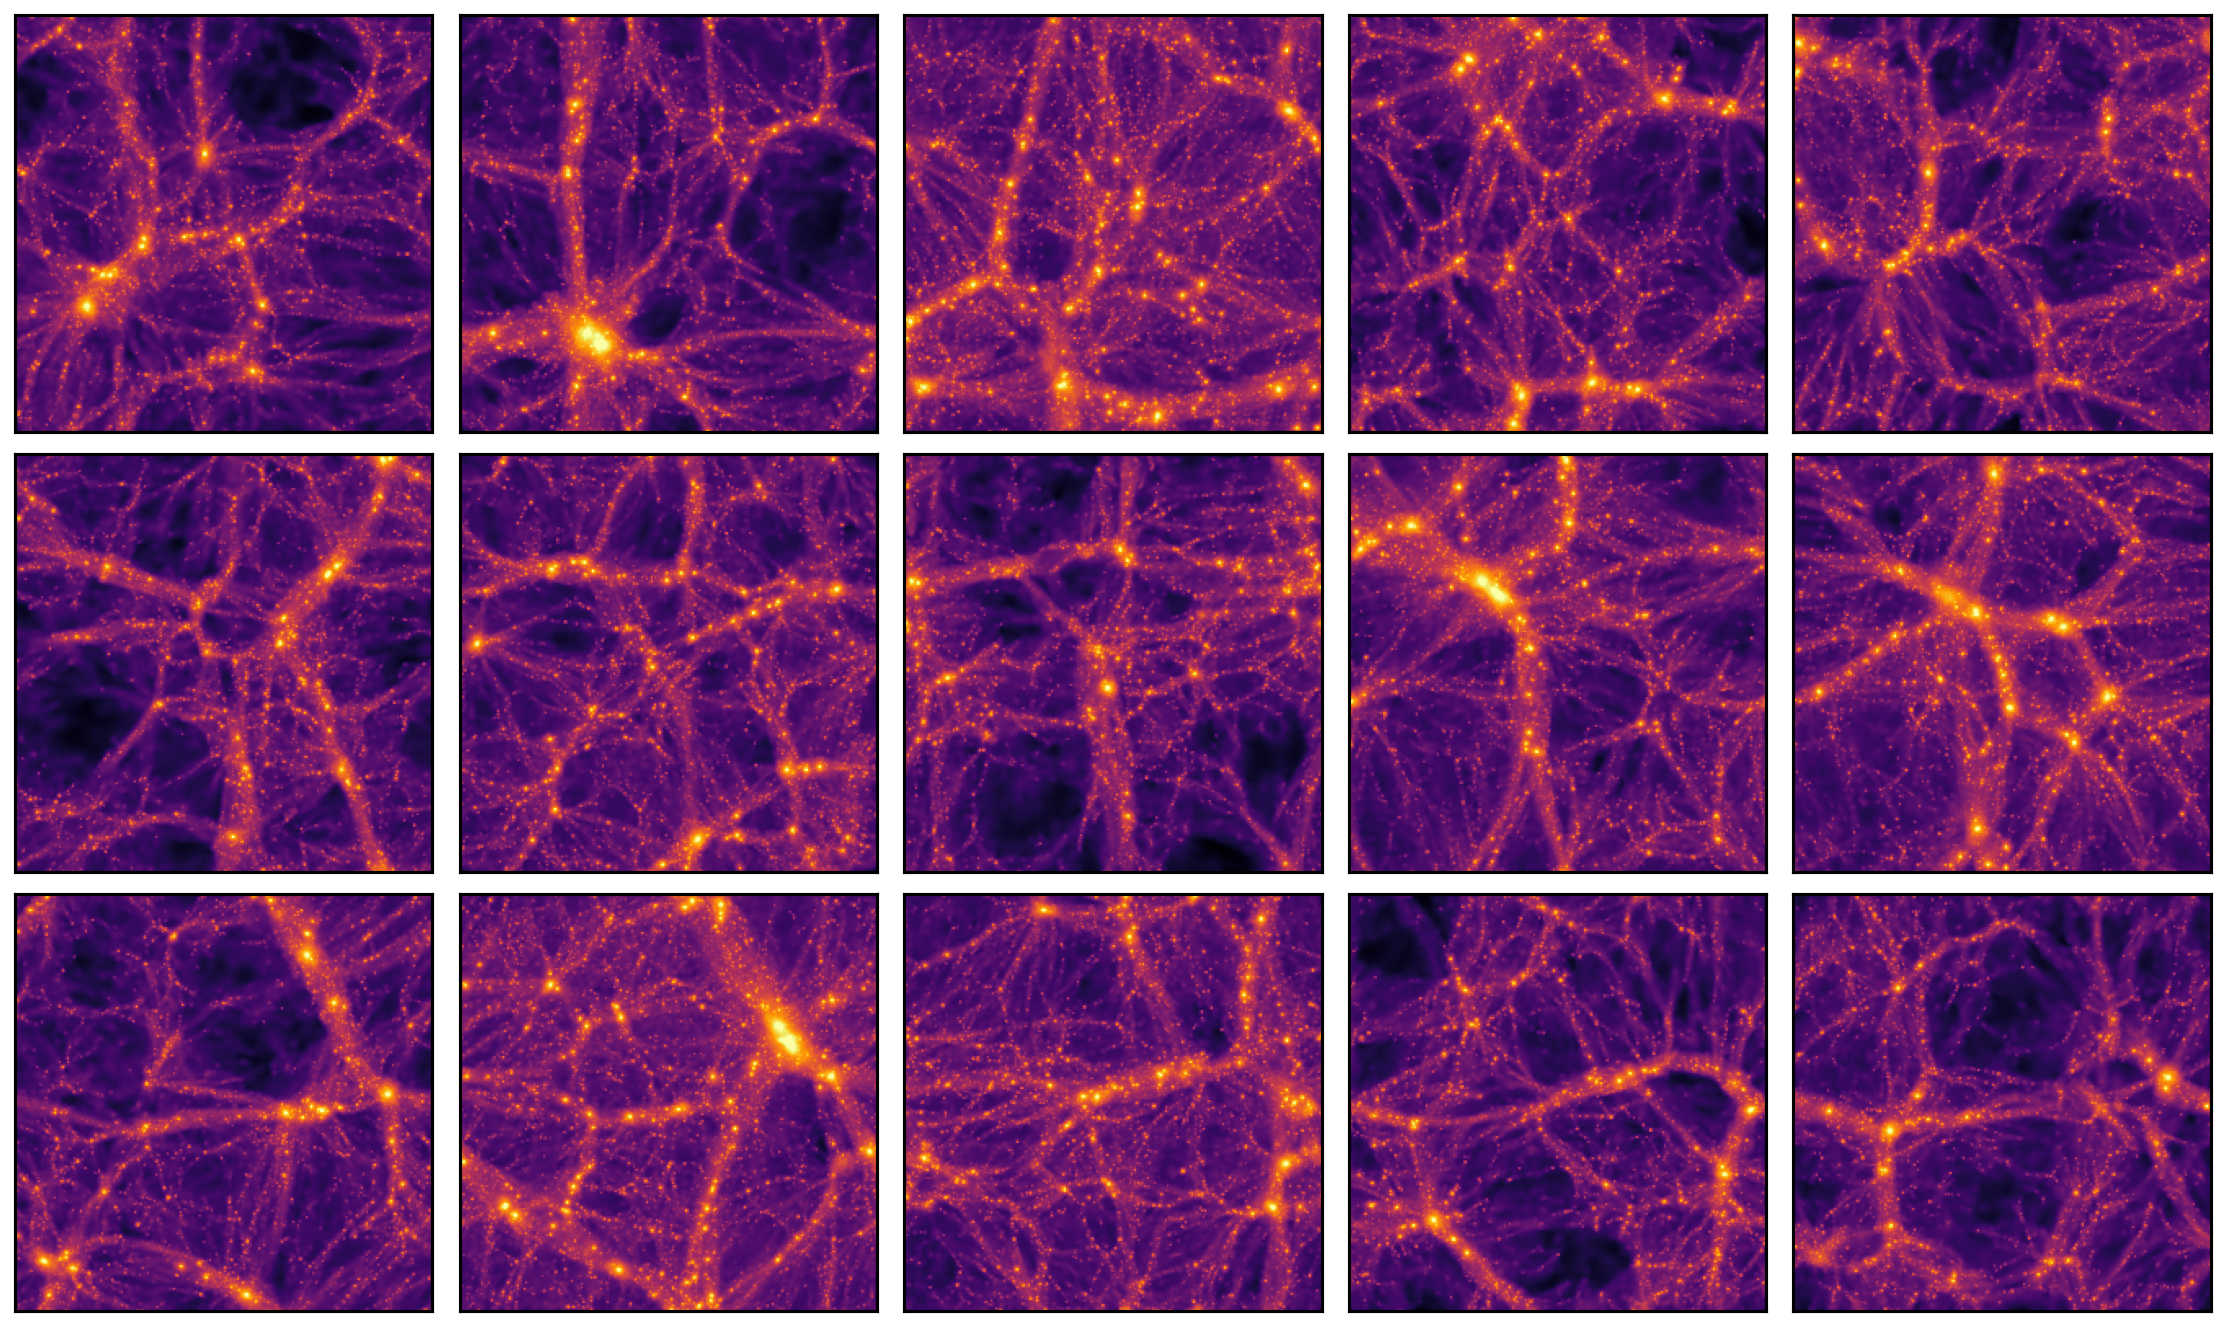

In [272]:
# visualise the first raw image, using log scale
mass_index = 5
epsilon = 0.005
omegam_mean = 0.49
sigma8_mean = 0.8
OmegaM_range = [omegam_mean-epsilon,omegam_mean+epsilon]
sigma8_range = [sigma8_mean-4*epsilon,sigma8_mean+4*epsilon]
valid_indices = ((WDM_params[:, 0] > OmegaM_range[0]) & (WDM_params[:, 0] < OmegaM_range[1]) & (WDM_params[:, 1] > sigma8_range[0]) & (WDM_params[:, 1] < sigma8_range[1]))
# finding the nth largest value in an array
index = np.argsort(WDM_params[:,mass_index])[-1]
error = 5e-1
target = 6 # keV
index = np.where((WDM_params[:,mass_index] >= 1./(target + error)) & (WDM_params[:,mass_index] <= 1./(target - error)) & valid_indices)[0][0]
print(index)
vmin = 1e10; vmax = 1e14
#vmin = None; vmax = None
print(f'Params: {WDM_params[index]}')
#plt.figure(figsize=(6,6))
print(f'WDM mass: {1./WDM_params[index][mass_index]} keV, OmegaM: {WDM_params[index][np.where(np.array(WDM_param_names) == "OmegaM")[0][0]]}, Sigma8: {WDM_params[index][np.where(np.array(WDM_param_names) == "sigma8")[0][0]]}')
#plt.imshow(raw_images[15*index + 3], norm=LogNorm(vmin=1e10, vmax=1e14), cmap='inferno')
#plt.colorbar()
#plt.yticks([]); plt.xticks([])
#plt.tight_layout()

# Now, visualise all 15 images for the same WDM mass in a 3x5 grid
plt.figure(figsize=(15,9))
#plt.title(f'WDM mass: {1./WDM_params[index][mass_index]} eV')
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(raw_images[15*index + i], norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')
    plt.yticks([]); plt.xticks([])
#plt.colorbar()
plt.tight_layout()
plt.show()


## Defining the training parameters

In [7]:
##################################### INPUT ##########################################
# architecture parameters

WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])

# simulation suite
sim = 'WDM'
suite = 'TNG'

arch  = 'o3'
beta1 = 0.5
beta2 = 0.999

# data parameters
root_out        = f'results/' #output folder
root_maps       = f'images/' #folder with the maps
root_storage    = 'sqlite:///databases_%s_%s/%s'%(sim,suite,arch)
f_params        = f'./WDM_TNG_params_1000.txt'
f_maps          = [f'./Images_Nbody_WDM_TNG_z=0.00.npy']
f_maps_norm     = [None]
seed            = 1               #random seed to initially mix the maps
splits          = 15 #51 #15             #number of maps per simulation
z               = 0.00            #redshift
monopole        = True  #keep the monopole of the maps (True) or remove it (False)
#fields          = ['Nbody']  #nbody, om_Nbody
#fields          = ['Mgas', 'Mstar', 'T', 'Z', 'P', 'HI', 'ne', 'MgFe'] #hydro
#fields          = ['Nbody','Mgas', 'Mstar', 'T', 'Z', 'P', 'HI', 'ne', 'MgFe'] #All
#fields           = ['Vgas', 'Vcdm', 'Mtot'] #hydro_other
#fields          = ['Nbody', 'Mtot', 'Mgas', 'P', 'HI', 'ne'] #good, good_long
#fields          = ['Mstar', 'T', 'Z', 'MgFe', 'Vgas', 'Vcdm'] #bad 
fields          = ['B']
params          = [5]
rot_flip_in_mem = False  #whether rotations and flipings are kept in memory
smoothing       = 0 #Gaussian smoothing in pixels units
label           = f'all_steps_500_500_o3'

# training parameters
batch_size  = 128 #128
min_lr      = 1e-9
epochs      = 200 # increase for grokking? Ask Paco?
num_workers = 0  #number of workers to load data

# optuna parameters
#nbody, hydro, all
study_name = f'wd_dr_hidden_lr_{arch}_smoothing{smoothing}_z{z}_B'
n_trials   = 50

## Prepping the Data

In [8]:
# This routine takes set of maps and smooth them with a Gaussian kernel
def smooth_maps(maps, smoothing, verbose=True):
    
    if verbose:  print('Smoothing images with smoothing length: %d'%smoothing)

    # do a loop over all maps
    for i in range(maps.shape[0]):
        image = maps[i]
        maps[i] = scipy.ndimage.gaussian_filter(image, smoothing, mode='wrap')

    return maps

# This routine takes a set of maps and remove their monopole (i.e. average value)
def remove_monopole(maps, verbose=True):

    if verbose:  print('removing monopoles')

    # compute the mean of each map
    maps_mean = np.mean(maps, axis=(1,2), dtype=np.float64)

    # do a loop over all maps and remove mean value
    for i in range(maps.shape[0]):
        maps[i] = maps[i] - maps_mean[i]

    return maps

In [9]:
# This class creates the dataset. It will read the maps and store them in memory
# the rotations and flipings are done when calling the data 
class make_dataset_multifield2():

    def __init__(self, mode, seed, f_images, f_params, splits, f_images_norm, 
                 monopole, monopole_norm, smoothing, smoothing_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(f_params) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]   # filling up the full params array for each individual image/map

        # normalize params
        #minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
        #maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
        #params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  
            offset, size_sims = int(0.00*total_sims), int(0.90*total_sims) # first 90% of sims
        elif mode=='valid':  
            offset, size_sims = int(0.90*total_sims), int(0.05*total_sims) # next 5% of sims
        elif mode=='test':  
            offset, size_sims = int(0.95*total_sims), int(0.05*total_sims) # last 5% of sims
        elif mode=='all':  
            offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:    raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a 
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(f_images)
        dumb     = np.load(f_images[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(f_images, f_images_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # smooth the images
            if smoothing>0:  data_c = smooth_maps(data_c, smoothing, verbose); print('Smoothing done')

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # remove monopole of the images
            if monopole is False:  data_c = remove_monopole(data_c, verbose); print('Monopole removed')

            ############################## SR EDIT #####################################################
            #### SLIGHT BUG? SHOULDN'T BE COMPUTING MEAN, STD FROM ALL MAPS, NOT JUST TRAINING SET? ####
            ############################## SR EDIT #####################################################
            # normalize maps
            if fnorm is None:  
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # smooth data
                if smoothing_norm>0:  
                    data_norm = smooth_maps(data_norm, smoothing_norm, verbose)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # remove monopole
                if monopole_norm is False:
                    data_norm = remove_monopole(data_norm, verbose)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            #data = 2*(data - minimum)/(maximum - minimum) - 1.0
            data_c = (data_c - mean)/std
            if verbose:  
                print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c))) 

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

            #if verbose:
            #    print('Channel %d contains %d maps'%(channel,counted_maps))
            #    print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))
        
        print(f'Data shape (maps, channels, height, width): {data.shape}')
        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

        #vutils.save_image(self.x, 'images.png', nrow=10, normalize=True)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)
        
        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]


#checks to make sure testing set is at least somewhat distributed - JONAH EDIT
def check_test_conditions(sim_numbers, params_sims):
    total_sims = len(sim_numbers)
    beg = int(0.95*total_sims)
    test_set = sim_numbers[beg:]

    inv_params = 1 / params_sims

    #check if they have been shuffled
    if np.sum(np.diff(sim_numbers)) == total_sims:
        return False
    #check if at least one sim from the first quarter is in testing set 
    if np.sum(inv_params[test_set] > 25) == 0:
        return False
    #check if at least one sim from the first quarter is in testing set 
    if np.sum((inv_params[test_set] > 20) & (inv_params[test_set] < 25)) == 0:
        return False
    #check if at least one sim from the first quarter is in testing set 
    if np.sum((inv_params[test_set] > 10) & (inv_params[test_set] < 20)) == 0:
        return False
    #check if at least one sim from the first quarter is in testing set 
    if np.sum((inv_params[test_set] > 5) & (inv_params[test_set] < 10)) == 0:
        return False

    return True






In [10]:
# This class creates the dataset. Rotations and flippings are done and stored
class make_dataset_multifield():

    def __init__(self, mode, seed, f_images, f_params, splits, f_images_norm, 
                 monopole, monopole_norm, just_monopole, smoothing, smoothing_norm, 
                 verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(f_params) #simulations parameters, NOT maps parameters
        total_sims, total_maps = params_sims.shape[0], params_sims.shape[0]*splits
        num_params = 1 if len(params_sims.shape)==1 else params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize params
        #minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        #maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        #minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
        #maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
        #params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  
            offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  
            offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':  
            offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':  
            offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:    raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a 
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps

        #while not check_test_conditions(sim_numbers, params_sims): #JONAH EDIT
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        #print(mode, 1/params_sims[sim_numbers])

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        #print(mode)
        #print(params_maps)

        # define the matrix containing the maps with rotations and flipings
        channels = len(f_images)
        dumb     = np.load(f_images[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(f_images, f_images_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(fim, data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # smooth the images
            if smoothing>0:  data_c = smooth_maps(data_c, smoothing)

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # remove monopole of the images
            if monopole is False:  data_c = remove_monopole(data_c, verbose)

            ############################## SR EDIT #####################################################
            #### SLIGHT BUG? SHOULDN'T BE COMPUTING MEAN, STD FROM ALL MAPS, NOT JUST TRAINING SET? ####
            ############################## SR EDIT #####################################################
            # normalize maps
            if fnorm is None:  
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # smooth maps
                if smoothing_norm>0:  
                    data_norm = smooth_maps(data_norm, smoothing_norm, verbose)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # remove monopole
                if monopole_norm is False:
                    data_norm = remove_monopole(data_norm, verbose)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            # whether to make maps with the mean value in all pixels
            if just_monopole:
                data_c = 10**(data_c)
                mean_each_map = np.mean(data_c, axis=(1,2))
                for i in range(data_c.shape[0]):
                    data_c[i] = mean_each_map[i]
                data_c = np.log10(data_c)

            #data = 2*(data - minimum)/(maximum - minimum) - 1.0
            data_c = (data_c - mean)/std
            if verbose:  
                print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c))) 

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps
            
            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))
                
        
        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

        #vutils.save_image(self.x, 'images.png', nrow=10, normalize=True)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        """
        shape = (self.x[idx]).shape
        indexes = np.arange(torch.numel(self.x[idx]))
        np.random.shuffle(indexes)
        shuffled_map = self.x[idx].view(-1)
        shuffled_map = shuffled_map[indexes]
        shuffled_map = shuffled_map.view(shape)
        return shuffled_map, self.y[idx]
        """
        return self.x[idx], self.y[idx]

In [11]:
# This routine creates the dataset for the multifield analysis
# mode ------------> 'train', 'valid', 'test', 'test2', 'all'
# seed ------------> seed to randomly mix the maps into train|valid|test
# f_images --------> tuple containing the names of the fields to consider, e.g.
#                  > ['Images_IllustrisTNG_P_LH_z=0.00.npy',
#                  >  'Images_IllustrisTNG_T_LH_z=0.00.npy']
# f_params --------> name of file with value of the simulation (not maps) parameters
# batch_size ------> batch size
# splits ----------> total number of maps in a single simulation
# f_images_norm ---> tuple containing the names of the images used to normalize the data
#                  > (e.g. to compute mean and std), e.g.:
#                  > ['Images_IllustrisTNG_Mcdm_LH_z=0.00.npy',
#                  >  'Images_IllustrisTNG_Mgas_LH_z=0.00.npy']
#                  > If this data is the same as f_images, then set
#                  > f_images_norm = [None, None]
# num_workers -----> number of cores use to load the data
# monopole --------> Whether to remove the mean of each image or not
# monopole_norm ---> Whether to remove the mean of each image in the normalization set
# rot_flip_in_mem -> whether the dataset contains all rotations and flippings or not
#                  > if True, it will be faster and more efficient, but will use more
#                  > memory. If False, the rotations and flippings are randomly done
#                  > when calling the routine. For validation and testing always set it
#                  > to True. When combining different fields as channels, set it to 
#                  > False or it will not fit in memory.
# shuffle ---------> whether randomly shuffle the data
# just_monopole ---> whether redo images just containing the monopole (only for testing)
# smoothing -------> smooth images with Gaussian kernel; integer with number of pixels
# smoothing_norm --> the smoothing level of the maps used for the normalization
# verbose ---------> prints information about the progress
def create_dataset_multifield(mode, seed, f_images, f_params, batch_size, splits, 
                              f_images_norm, num_workers=1, monopole=True, 
                              monopole_norm=True, rot_flip_in_mem=True, shuffle=True, 
                              just_monopole=False, smoothing=0, smoothing_norm=0, 
                              verbose=False):

    '''# whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, f_images, f_params, splits, 
                                           f_images_norm, monopole, monopole_norm, 
                                           just_monopole, smoothing, smoothing_norm, 
                                           verbose)
    else:'''
    data_set = make_dataset_multifield2(mode, seed, f_images, f_params, splits, 
                                        f_images_norm, monopole, monopole_norm, 
                                        smoothing, smoothing_norm, verbose)

    '''data_set = make_dataset_multifield(mode, seed, f_images, f_params, splits, 
                                        f_images_norm, monopole, monopole_norm, just_monopole, 
                                        smoothing, smoothing_norm, verbose)'''

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle,
                             num_workers=num_workers)
    
    del data_set
    
    return data_loader

In [ ]:
train_loader = create_dataset_multifield('train', seed, f_maps, 
                    f_params, batch_size, splits, f_maps_norm, 
                    num_workers=num_workers, monopole=monopole, 
                    rot_flip_in_mem=rot_flip_in_mem, smoothing=smoothing, 
                    verbose=True)
valid_loader = create_dataset_multifield('valid', seed, f_maps, 
                    f_params, batch_size, splits, f_maps_norm, 
                    num_workers=num_workers, monopole=monopole, 
                    rot_flip_in_mem=rot_flip_in_mem, smoothing=smoothing, 
                    verbose=True)
test_loader = create_dataset_multifield('test', seed, f_maps, 
                    f_params, batch_size, splits, f_maps_norm, 
                    num_workers=num_workers, monopole=monopole, 
                    rot_flip_in_mem=rot_flip_in_mem, smoothing=smoothing, 
                    verbose=True)


Found 1 channels
Reading data...
3.156e+09 < F(all|orig) < 2.647e+15
9.499 < F(all|resc)  < 15.423
-2.918 < F(all|norm) < 8.729
Data shape (maps, channels, height, width): (13500, 1, 256, 256)
Found 1 channels
Reading data...
3.156e+09 < F(all|orig) < 2.647e+15
9.499 < F(all|resc)  < 15.423
-2.918 < F(all|norm) < 8.729
Data shape (maps, channels, height, width): (750, 1, 256, 256)
Found 1 channels
Reading data...
3.156e+09 < F(all|orig) < 2.647e+15
9.499 < F(all|resc)  < 15.423
-2.918 < F(all|norm) < 8.729
Data shape (maps, channels, height, width): (750, 1, 256, 256)


In [11]:
# check the size of the dataset
print('Number of training maps: %d'%len(train_loader.dataset))
print('Number of validation maps: %d'%len(valid_loader.dataset))
print('Number of testing maps: %d'%len(test_loader.dataset))

Number of training maps: 13500
Number of validation maps: 750
Number of testing maps: 750


In [12]:
# check y values of the datasets
training_masses = 1./(train_loader.dataset.y*(maximum-minimum) + minimum)[:,5]
validation_masses = 1./(valid_loader.dataset.y*(maximum-minimum) + minimum)[:,5]
testing_masses = 1./(test_loader.dataset.y*(maximum-minimum) + minimum)[:,5]
print(f'WDM values of training set: Min: {torch.min(training_masses)}, Max: {torch.max(training_masses)}, Median: {torch.median(training_masses)}')
print(f'WDM values of validation set: Min: {torch.min(validation_masses)}, Max: {torch.max(validation_masses)}, Median: {torch.median(validation_masses)}')
print(f'WDM values of testing set: Min: {torch.min(testing_masses)}, Max: {torch.max(testing_masses)}, Median: {torch.median(testing_masses)}')

WDM values of training set: Min: 1.800907272586152, Max: 15.995710078447408, Median: 3.176539131161901
WDM values of validation set: Min: 1.8461109530691857, Max: 14.1054060685348, Median: 3.6101551601040978
WDM values of testing set: Min: 1.8134042224936757, Max: 15.579826541547657, Median: 3.971877541965496


## Training the network

In [13]:
## defining the model class
class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()
        
        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1, 
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1, 
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0, 
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)
        
        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)
        
        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)
        
        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)
        
        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)
        
        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B51 = nn.BatchNorm2d(64*hidden)
        self.B52 = nn.BatchNorm2d(64*hidden)
        self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*hidden, 128*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(128*hidden)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*hidden, 64*hidden)  
        self.FC2  = nn.Linear(64*hidden, 12)  

        self.dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):

        x = self.LeakyReLU(self.C01(image))
        x = self.LeakyReLU(self.B02(self.C02(x)))
        x = self.LeakyReLU(self.B03(self.C03(x)))

        x = self.LeakyReLU(self.B11(self.C11(x)))
        x = self.LeakyReLU(self.B12(self.C12(x)))
        x = self.LeakyReLU(self.B13(self.C13(x)))

        x = self.LeakyReLU(self.B21(self.C21(x)))
        x = self.LeakyReLU(self.B22(self.C22(x)))
        x = self.LeakyReLU(self.B23(self.C23(x)))

        x = self.LeakyReLU(self.B31(self.C31(x)))
        x = self.LeakyReLU(self.B32(self.C32(x)))
        x = self.LeakyReLU(self.B33(self.C33(x)))

        x = self.LeakyReLU(self.B41(self.C41(x)))
        x = self.LeakyReLU(self.B42(self.C42(x)))
        x = self.LeakyReLU(self.B43(self.C43(x)))

        x = self.LeakyReLU(self.B51(self.C51(x)))
        x = self.LeakyReLU(self.B52(self.C52(x)))
        x = self.LeakyReLU(self.B53(self.C53(x)))

        x = self.LeakyReLU(self.B61(self.C61(x)))

        x = x.view(image.shape[0],-1)
        x = self.dropout(x)
        x = self.dropout(self.LeakyReLU(self.FC1(x)))
        x = self.FC2(x)

        # enforce the errors to be positive
        y = torch.clone(x)
        y[:,6:12] = torch.square(x[:,6:12])
        #y[:,1] = torch.square(x[:,1])
        #y[:,2:4] = torch.square(x[:,2:4])
        return y

In [14]:

##################################### INPUT ##########################################
# architecture parameters

# simulation suite
sim = 'WDM'
suite = 'TNG'

arch  = 'o3'
beta1 = 0.5
beta2 = 0.999

# data parameters
root_out        = f'results/' #output folder
root_maps       = f'images/' #folder with the maps
root_storage    = 'sqlite:///databases_%s_%s/%s'%(sim,suite,arch)
f_params        = f'./WDM_TNG_params_1000.txt'
seed            = 1               #random seed to initially mix the maps
splits          = 15 #51 #15             #number of maps per simulation
z               = 0.00            #redshift
monopole        = True  #keep the monopole of the maps (True) or remove it (False)
#fields          = ['Nbody']  #nbody, om_Nbody
#fields          = ['Mgas', 'Mstar', 'T', 'Z', 'P', 'HI', 'ne', 'MgFe'] #hydro
#fields          = ['Nbody','Mgas', 'Mstar', 'T', 'Z', 'P', 'HI', 'ne', 'MgFe'] #All
#fields           = ['Vgas', 'Vcdm', 'Mtot'] #hydro_other
#fields          = ['Nbody', 'Mtot', 'Mgas', 'P', 'HI', 'ne'] #good, good_long
#fields          = ['Mstar', 'T', 'Z', 'MgFe', 'Vgas', 'Vcdm'] #bad 
fields          = ['B']
params          = [5]
rot_flip_in_mem = False  #whether rotations and flipings are kept in memory
smoothing       = 0 #Gaussian smoothing in pixels units
label           = f'all_steps_500_500_o3'

# training parameters
batch_size  = 128 #128
min_lr      = 1e-9
epochs      = 200 # increase for grokking? Ask Paco?
num_workers = 0  #number of workers to load data

# optuna parameters
#nbody, hydro, all
study_name = f'wd_dr_hidden_lr_{arch}_smoothing{smoothing}_z{z}_B'
n_trials   = 50
######################################################################################

# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
#cudnn.benchmark = True      #May train faster but cost more memory


# get the name of files containing the maps and the databases
f_maps, f_maps_norm, suffix = U.fname_maps(root_maps, fields, sim, z, suite=suite)
storage_m = U.fname_storage(root_storage, fields, label, monopole=monopole)

print("Storage:", storage_m)
print(f_maps, f_maps_norm)

# train networks with bayesian optimization
## NOTE: I DON'T REALLY WANT TO USE OPTUNA INITIALLY. I SHOULD JUST USE THE BEST TRAINING PARAMETERS
#objective = Objective(device, seed, f_maps, f_params, batch_size, splits, f_maps_norm, 
#                      arch, min_lr, beta1, beta2, epochs, root_out, fields, monopole, study_name, 
#                      label, num_workers, params, rot_flip_in_mem, sim, smoothing)

#sampler = optuna.samplers.TPESampler(n_startup_trials=20)
#study = optuna.create_study(study_name=study_name, sampler=sampler, storage=storage_m,
#                            load_if_exists=True)
#study.optimize(objective, n_trials, gc_after_trial=False)

CUDA Not Available
Storage: sqlite:///databases_WDM_TNG/o3_B_all_steps_500_500_o3.db
['images//Images_B_WDM_TNG_z=0.00.npy'] [None]


In [15]:
#Objective(device, seed, f_maps, f_params, batch_size, splits, f_maps_norm, 
#            arch, min_lr, beta1, beta2, epochs, root_out, fields, monopole, study_name, 
#            label, num_workers, params, rot_flip_in_mem, sim, smoothing)

#def __init__(self, device, seed, f_maps, f_params, batch_size, splits, f_maps_norm, 
#                 arch, min_lr, beta1, beta2, epochs, root_out, fields, monopole, sname, 
#                 label, num_workers, params, rot_flip_in_mem, sim, smoothing):

#class model_o3_err(nn.Module):
#    def __init__(self, hidden, dr, channels):

# get the number of channels in the maps
channels  = len(fields)
criterion = nn.MSELoss()

# tuple with the indexes of the parameters to train
g = params      #posterior mean
#h = [1+i for i in g] #posterior variance
h = [6+i for i in g]

# get the value of the hyperparameters
#max_lr = trial.suggest_float("lr", 1e-5, 5e-3, log=True)
#wd     = trial.suggest_float("wd", 1e-8, 1e-1, log=True)
#dr     = trial.suggest_float("dr", 0.0,  0.9)
#hidden = trial.suggest_int("hidden", 6, 12)

# optimum hyperparams found by Jonah with Optuna
max_lr = 0.003081406540122628
wd     = 0.0012352939003943669
dr     = 0.4044701879352993
hidden = 11

# some verbose
#print('\nTrial number: {}'.format(trial.number))
print('Fields: {}'.format(fields))
print('lr: {}'.format(max_lr))
print('wd: {}'.format(wd))
print('dr: {}'.format(dr))
print('hidden: {}'.format(hidden))

# define architecture
model = model_o3_err(hidden, dr, channels)
if torch.cuda.device_count() > 1:
    print("Using %d GPUs"%(torch.cuda.device_count()))
    model = nn.DataParallel(model)

model.to(device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd,
                            betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=min_lr, 
                    max_lr=max_lr, cycle_momentum=False, step_size_up=500,
                                            step_size_down=500)


Fields: ['B']
lr: 0.003081406540122628
wd: 0.0012352939003943669
dr: 0.4044701879352993
hidden: 11
total number of parameters in the model = 28436376


In [ ]:
## TRAIN THE DARN THING!!

# get validation loss
print('Computing initial validation loss')
model.eval()
valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
    with torch.no_grad():
        print('Batch:', points)
        bs   = x.shape[0]                #batch size
        x    = x.to(device=device)       #maps
        y    = y.to(device=device)[:,g]  #parameters
        p    = model(x)                  #NN output
        y_NN = p[:,g]                    #posterior mean
        e_NN = p[:,h]                    #posterior std
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
        loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
        valid_loss1 += loss1*bs
        valid_loss2 += loss2*bs
        points += bs
min_valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
min_valid_loss = torch.mean(min_valid_loss).item()
print('Initial valid loss = %.3e'%min_valid_loss)

old_p = []
train_losses = []
valid_losses = []
test_losses = []

fmodel = root_out + f'model_%s_lr{%.1e}_wd{%.1e}_dr{%.2f}_hidden{%d}.pt'%(label, max_lr, wd, dr, hidden)

# do a loop over all epochs
start = time.time()
#for epoch in range(epochs):
for epoch in range(1):
    print('Epoch:', epoch)

    # do training
    train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        #print('Batch:', points)
        bs   = x.shape[0]         #batch size
        x    = x.to(device)       #maps
        y    = y.to(device)[:,g]  #parameters
        p    = model(x)           #NN output
        y_NN = p[:,g]             #posterior mean
        e_NN = p[:,h]             #posterior std
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
        loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
        train_loss1 += loss1*bs
        train_loss2 += loss2*bs
        points      += bs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        #print('loss:', loss)

        if points>18000:  break
    train_loss = torch.log(train_loss1/points) + torch.log(train_loss2/points)
    train_loss = torch.mean(train_loss).item()

    # do validation: cosmo alone & all params
    valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    valid_loss, points = 0.0, 0
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            bs    = x.shape[0]        #batch size
            x     = x.to(device)       #maps
            y     = y.to(device)[:,g]  #parameters
            p     = model(x)           #NN output
            y_NN  = p[:,g]             #posterior mean
            e_NN  = p[:,h]             #posterior std
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            valid_loss1 += loss1*bs
            valid_loss2 += loss2*bs
            points     += bs
    valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
    valid_loss = torch.mean(valid_loss).item()

    # do testing
    '''test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    test_loss, points = 0.0, 0
    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            x     = x.to(device)       #maps
            y     = y.to(device)[:,g]  #parameters
            p     = model(x)           #NN output
            y_NN  = p[:,g]             #posterior mean
            e_NN  = p[:,h]             #posterior std
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            test_loss1 += loss1*bs
            test_loss2 += loss2*bs
            points    += bs
    test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
    test_loss = torch.mean(test_loss).item()'''

    # verbose
    #print('%03d %.3e %.3e %.3e '%(epoch, train_loss, valid_loss, 
    #                                test_loss), end='')
    #print('%03d %.3e %.3e '%(epoch, train_loss, valid_loss), end='')
    print(f'epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # save model if it is better
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = valid_loss
        print('(C) ', end='')
    print('')

    # save losses to file
    #f = open(fout, 'a')
    #f.write('%d %.5e %.5e %.5e\n'%(epoch, train_loss, valid_loss, test_loss))
    #f.close()

# Handle pruning based on the intermediate value
# comment out these lines if using prunning
#trial.report(valid_loss, epoch)
#if trial.should_prune():  raise optuna.exceptions.TrialPruned()

stop = time.time()
print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))

# save losses to file
#mainfolder = './'
#np.savetxt(f'{mainfolder}/train_losses.txt', train_losses)
#np.savetxt(f'{mainfolder}/valid_losses.txt', valid_losses)
#np.savetxt(f'{mainfolder}/test_losses.txt', test_losses)


## Loading and evaluating the trained network

#### Basic load in and validation/testing check

In [3]:
## defining the model class
class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()
        
        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1, 
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1, 
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0, 
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)
        
        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)
        
        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)
        
        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)
        
        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)
        
        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B51 = nn.BatchNorm2d(64*hidden)
        self.B52 = nn.BatchNorm2d(64*hidden)
        self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*hidden, 128*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(128*hidden)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*hidden, 64*hidden)  
        self.FC2  = nn.Linear(64*hidden, 12)  

        self.dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):

        x = self.LeakyReLU(self.C01(image))
        x = self.LeakyReLU(self.B02(self.C02(x)))
        x = self.LeakyReLU(self.B03(self.C03(x)))

        x = self.LeakyReLU(self.B11(self.C11(x)))
        x = self.LeakyReLU(self.B12(self.C12(x)))
        x = self.LeakyReLU(self.B13(self.C13(x)))

        x = self.LeakyReLU(self.B21(self.C21(x)))
        x = self.LeakyReLU(self.B22(self.C22(x)))
        x = self.LeakyReLU(self.B23(self.C23(x)))

        x = self.LeakyReLU(self.B31(self.C31(x)))
        x = self.LeakyReLU(self.B32(self.C32(x)))
        x = self.LeakyReLU(self.B33(self.C33(x)))

        x = self.LeakyReLU(self.B41(self.C41(x)))
        x = self.LeakyReLU(self.B42(self.C42(x)))
        x = self.LeakyReLU(self.B43(self.C43(x)))

        x = self.LeakyReLU(self.B51(self.C51(x)))
        x = self.LeakyReLU(self.B52(self.C52(x)))
        x = self.LeakyReLU(self.B53(self.C53(x)))

        x = self.LeakyReLU(self.B61(self.C61(x)))

        x = x.view(image.shape[0],-1)
        x = self.dropout(x)
        x = self.dropout(self.LeakyReLU(self.FC1(x)))
        x = self.FC2(x)

        # enforce the errors to be positive
        y = torch.clone(x)
        y[:,6:12] = torch.square(x[:,6:12])
        #y[:,1] = torch.square(x[:,1])
        #y[:,2:4] = torch.square(x[:,2:4])
        return y

In [10]:
## Loading in the trained WDM_model.pt model

# optimum hyperparams found by Jonah with Optuna
max_lr = 0.003081406540122628
wd     = 0.0012352939003943669
dr     = 0.4044701879352993
hidden = 11
channels = 1
splits          = 15 #51 #15

model = model_o3_err(hidden, dr, channels)
#model.load_state_dict(torch.load('WDM_model.pt', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('WDM_model.pt', map_location=device))
print(f'Device: {device}')

Device: cpu


In [7]:
## Getting the data correctly formatted
raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy')
images_formatted = np.log10(raw_images)
mean = np.mean(images_formatted)
std = np.std(images_formatted)
images_formatted = (images_formatted - mean) / std 

In [8]:
## Loading in the parameters
f_params = 'WDM_TNG_params_1000.txt'
params = np.loadtxt(f_params)
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
params_maps = (params * (maximum - minimum)) + minimum

torch.Size([1, 1, 256, 256])
True: 3.084 keV, Predicted: 3.062 keV, Error: 0.507
2.150773e-08 0.07981331
0.0 1.0


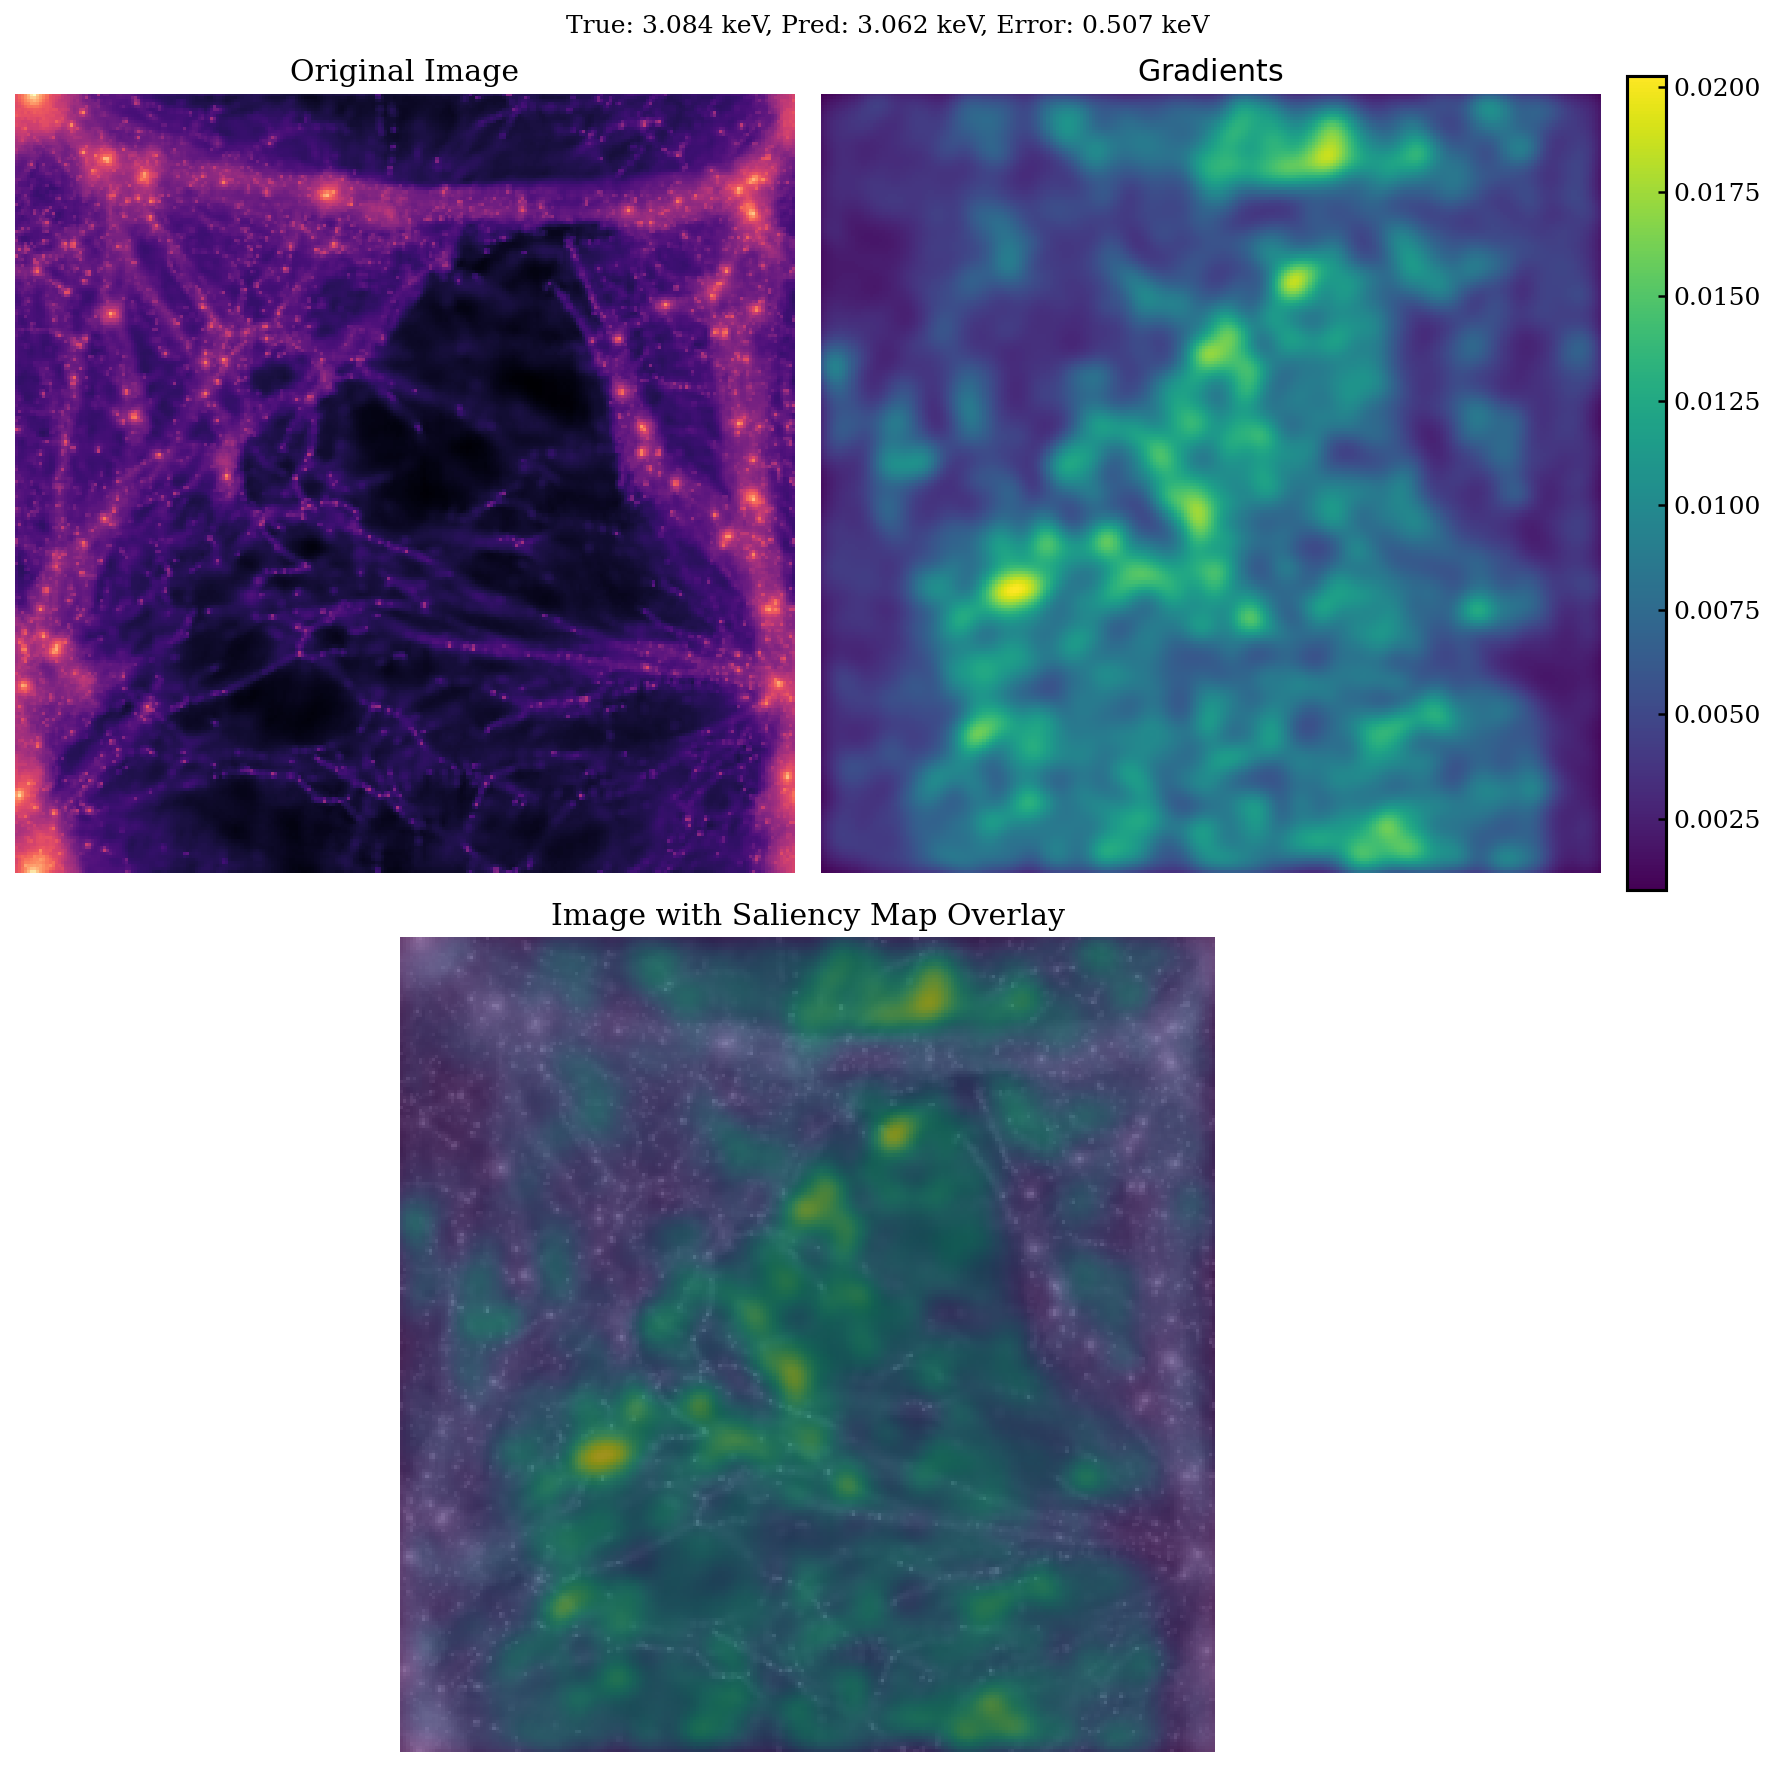

In [ ]:
## selecting a random image
#idx_im = 1200
idx_im = 1700
im = np.zeros((1, 256, 256))
im[0] = images_formatted[idx_im]
results = params_maps[idx_im // splits]

results = params_maps[idx_im // splits]

im = torch.tensor(im,dtype=torch.float).to(device=device) #.unsqueeze(0).to(device=device)
input = im.unsqueeze(0)
im = np.transpose(im.cpu().numpy(), (1,2,0))

input.requires_grad = True

print(input.shape)

model.eval()
pred = model(input)

predicted_value = pred.cpu().detach().numpy()[0]
predicted_results = (predicted_value[:6]* (maximum - minimum)) + minimum
predicted_errors = predicted_value[6:] * (maximum - minimum)

t = 1/results[5]
p = 1/predicted_results[5]
e = predicted_errors[5] * p * p #0
print(f"True: {np.round(t,3)} keV, Predicted: {np.round(p,3)} keV, Error: {np.round(e,3)}")

## Plotting the image
'''plt.figure(figsize=(6,6))
plt.imshow(im[:,:,0], cmap='magma')
plt.title(f'True: {np.round(t,3)} keV, Pred: {np.round(p,3)} keV, Error: {e:.3f}keV', fontsize=12)
plt.xticks([]); plt.yticks([]);'''

# Setting up the plot with gridspec to accommodate colorbar
#fig = plt.figure(figsize=(12, 6))
#gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # 0.05 for colorbar
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 0.05])  # 2 rows

#ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
#cax = plt.subplot(gs[2])  # Colorbar axes
ax1 = plt.subplot(gs[0,0])
# Plotting the original image
smap1 = ax1.imshow(im, cmap='magma')
ax1.set_title('Original Image')
ax1.axis('off')
ax1.set_aspect('equal')
# colorbar
#plt.colorbar(smap1)

plt.suptitle(f'True: {np.round(t,3)} keV, Pred: {np.round(p,3)} keV, Error: {e:.3f} keV', fontsize=12)
plt.tight_layout()
plt.show()

True 3.083613740720974 Predicted -0.9195411669034725 Error 6.2034158553765275


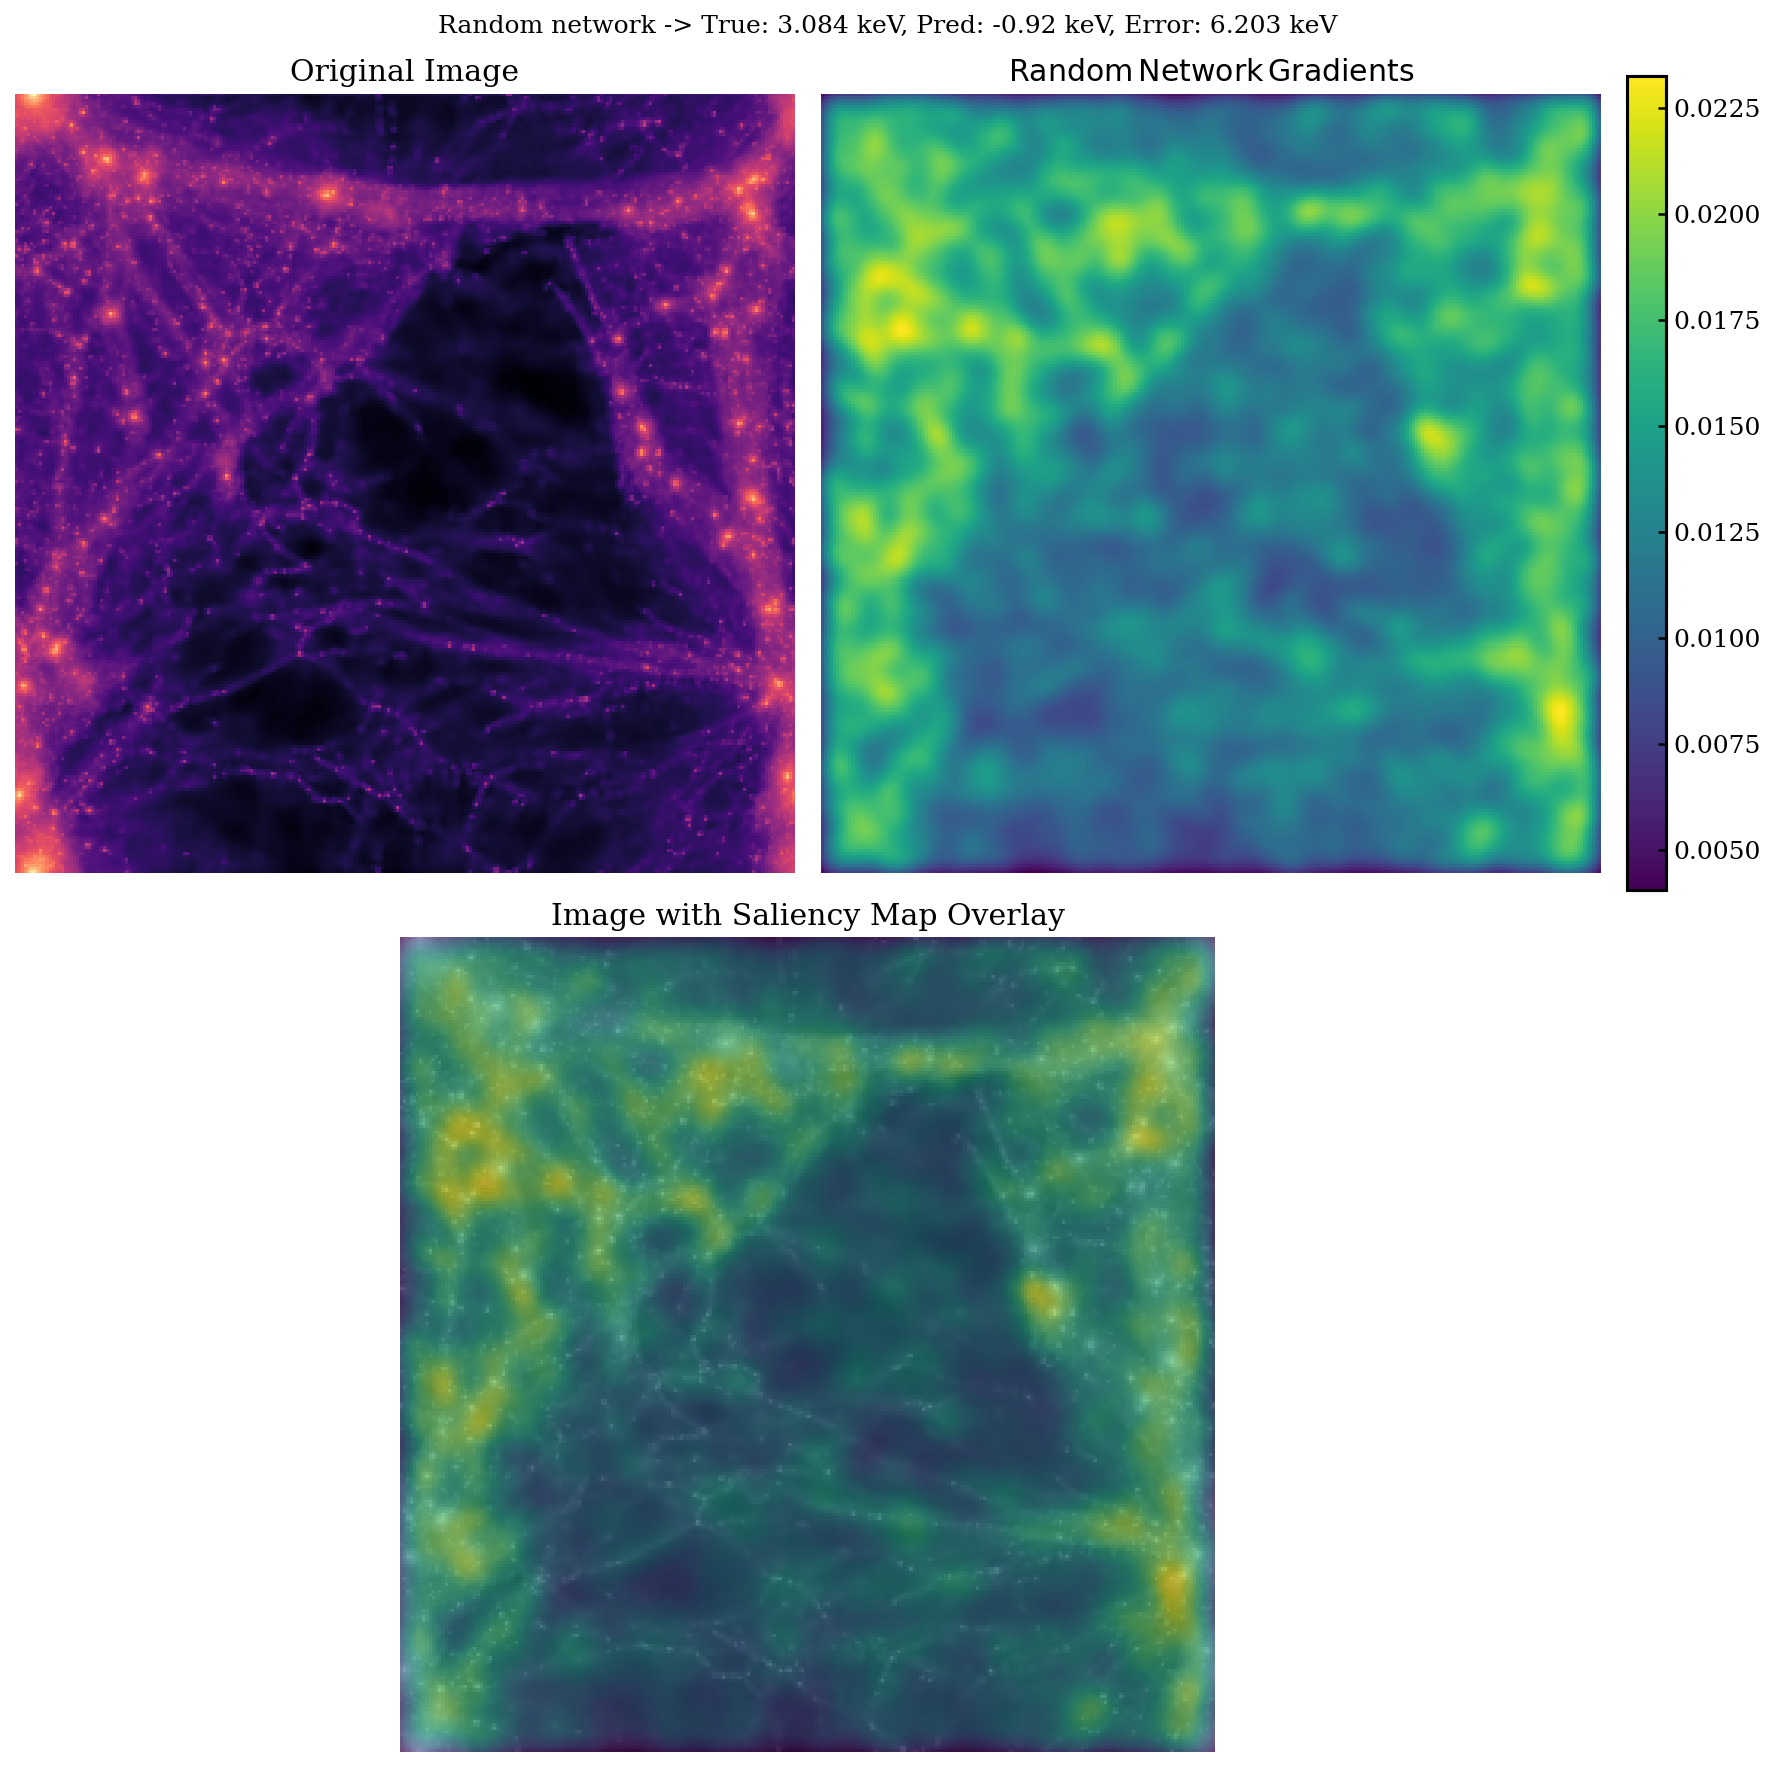

In [279]:
## Saliency map sanity check with completely random network initialisation

model_random = model_o3_err(hidden, dr, channels)

model_random.eval()
pred = model_random(input)

predicted_value = pred.cpu().detach().numpy()[0]
predicted_results = (predicted_value[:6]* (maximum - minimum)) + minimum
predicted_errors = predicted_value[6:] * (maximum - minimum)

t = 1/results[5]
p = 1/predicted_results[5]
e = predicted_errors[5] * p * p #0
print("True", t, "Predicted", p, "Error", e)

## Saliency map
#saliency_mode = 'Gradients'
#saliency_mode = 'IntegratedGradients'
#saliency_mode = 'GradientShap'

if saliency_mode == 'Gradients':
    saliency = Saliency(model_random.forward)
    grads_random = saliency.attribute(input, target=5) 
elif saliency_mode == 'GradXInput':
    saliency = InputXGradient(model_random.forward)
    grads_random = saliency.attribute(input, target=5)
elif saliency_mode == 'IntegratedGradients':
    saliency = IntegratedGradients(model_random)
    grads_random = saliency.attribute(input, target=5) 
elif saliency_mode == 'GradientShap':
    saliency = GradientShap(model_random.forward)
    #baselines = torch.randn(20,1,256,256)
    baselines = torch.zeros(1,1,256,256)
    grads_random = saliency.attribute(input, target=5, baselines=baselines)
elif saliency_mode == 'Occlusion':
    saliency = Occlusion(model_random.forward)
    # Attribute the prediction to the input image pixels
    grads_random = saliency.attribute(input, target=5, strides=strides, sliding_window_shapes=sliding_window_shapes, baselines=0)

grads_random = np.abs(grads_random.squeeze(0).cpu().detach().numpy())
#grads_random = (grads_random.squeeze(0).cpu().detach().numpy())
grads_random = np.transpose(grads_random, (1,2,0))

mi = np.min(grads_random)
ma = np.max(grads_random)
grads_random -= mi 
grads_random /=  ma - mi

## Plotting the image
'''plt.figure(figsize=(6,6))
plt.imshow(im[:,:,0], cmap='magma')
plt.title(f'True: {np.round(t,3)} keV, Pred: {np.round(p,3)} keV, Error: {e:.3f}keV', fontsize=12)
plt.xticks([]); plt.yticks([]);'''


# Setting up the plot with gridspec to accommodate colorbar
#fig = plt.figure(figsize=(12, 6))
#gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # 0.05 for colorbar
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 0.05])  # 2 rows

#ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
#cax = plt.subplot(gs[2])  # Colorbar axes
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
cax = plt.subplot(gs[0,2])  # Colorbar axes


# Plotting the original image
ax1.imshow(im, cmap='magma')
ax1.set_title('Original Image')
ax1.axis('off')

# smooth out the grads_ratio map
smoothed_grads_random = scipy.ndimage.gaussian_filter(grads_random, 4, mode='constant')

# Plotting the saliency map
#smap = ax2.imshow(np.log10(grads_random), cmap='hot', alpha=1.0, vmin=-2, vmax=0)
smap = ax2.imshow((smoothed_grads_random), cmap='viridis', alpha=1.0)
ax2.set_title(fr'$\rm{{Random\, Network\, {saliency_mode}}}$')
ax2.axis('off')

# Adding the colorbar
plt.colorbar(smap, cax=cax)

# Second row: Image with saliency map overlays
ax3 = plt.subplot(gs[1, :2])  # Span both columns for combined visualization
# black and white image
ax3.imshow(im, cmap='gray',alpha=1)
ax3.imshow((smoothed_grads_random), cmap='viridis', alpha=0.6)
ax3.set_title('Image with Saliency Map Overlay')
ax3.axis('off')

plt.suptitle(f'Random network -> True: {np.round(t,3)} keV, Pred: {np.round(p,3)} keV, Error: {e:.3f} keV', fontsize=12)
plt.tight_layout()
plt.show()


0.0 571.52765


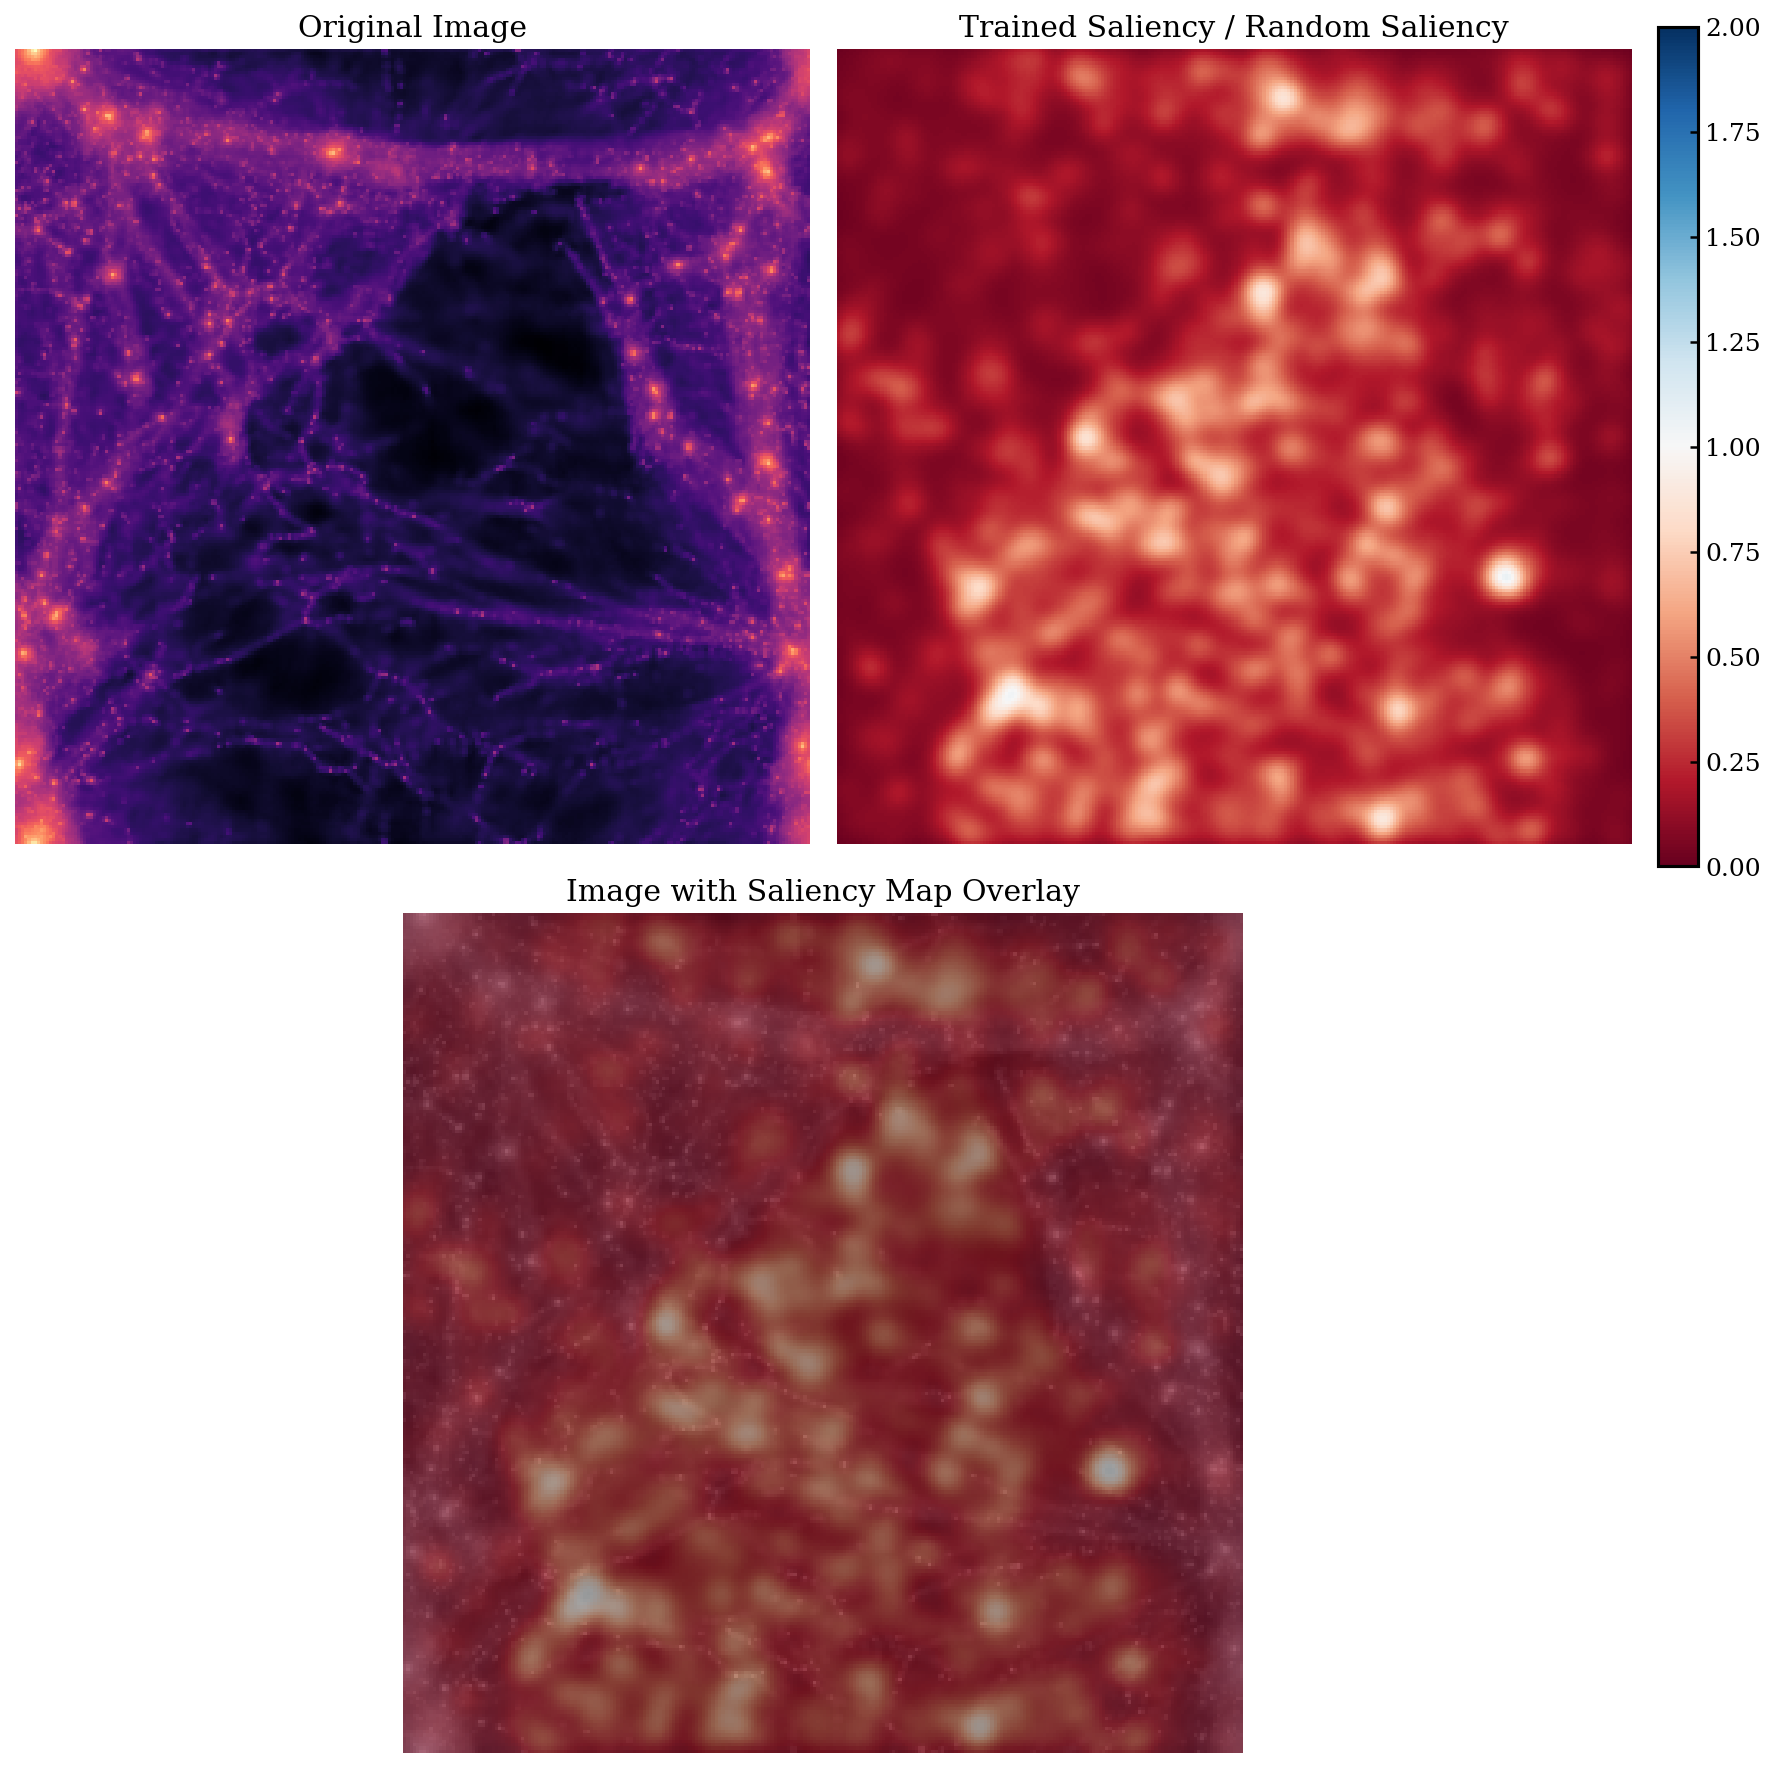

In [281]:
## plotting the ratio of the saliency map of the trained network to the random network

# computing the ratio of grads to grads_random, but setting the denominator to min value of 1e-5 to avoid division by zero
cutoff = 1e-3
grads_random_norm = grads_random
grads_random_norm[grads_random_norm < cutoff] = cutoff
grads_ratio = grads / grads_random_norm

print(grads_ratio.min(), grads_ratio.max())

# Setting up the plot
# Setting up the plot with gridspec to accommodate colorbar
#fig = plt.figure(figsize=(12, 6))
#gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # 0.05 for colorbar
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 0.05])  # 2 rows

#ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
#cax = plt.subplot(gs[2])  # Colorbar axes
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
cax = plt.subplot(gs[0,2])  # Colorbar axes


# Plotting the original image
dmmap = ax1.imshow(im, cmap='magma')
ax1.set_title('Original Image')
ax1.axis('off')

# smooth out the grads_ratio map
smoothed_grads_ratio = scipy.ndimage.gaussian_filter(grads_ratio, 4, mode='constant')

# Plotting the saliency map
#smap = ax2.imshow(np.log10(grads_ratio), cmap='RdBu', alpha=1.0,vmin=-1.5, vmax=1.5)
smap = ax2.imshow((smoothed_grads_ratio), cmap='RdBu', alpha=1.0,vmin=0,vmax=2)
ax2.set_title(f'Trained Saliency / Random Saliency')
ax2.axis('off')

# Adding the colorbar
plt.colorbar(smap, cax=cax)

# Second row: Image with saliency map overlays
ax3 = plt.subplot(gs[1, :2])  # Span both columns for combined visualization
# black and white image
ax3.imshow(im, cmap='gray',alpha=1)
ax3.imshow((smoothed_grads_ratio), cmap='RdBu', alpha=0.6,vmin=0,vmax=2)
ax3.set_title('Image with Saliency Map Overlay')
ax3.axis('off')


#plt.suptitle(f'True: {np.round(t,3)} keV, Pred: {np.round(p,3)} keV, Error: {e:.3f} keV', fontsize=12)
plt.tight_layout()
plt.show()

In [153]:
# reshape shape to 256x256
grads_ratio_reshaped = grads_ratio.squeeze(2)
print(grads_ratio_reshaped.shape)

(256, 256)


In [156]:
np.where((grads_random) == np.inf)
[np.min((grads_random)), np.max((grads_random))] 

[0.0, 1.0]

In [ ]:
## Plot the correlation between the saliency map of the trained network and the random network

# a function that computes the spatial correlation between grads and grads_random
def compute_spatial_correlation(grads, grads_random):
    # flatten the grads and grads_random arrays
    grads = grads.flatten()
    grads_random = grads_random.flatten()

    # compute the correlation
    corr = np.corrcoef(grads, grads_random)[0,1]

    return corr



In [201]:
car_data = np.loadtxt('./../tabular_car_data_Cd_height_width_area.csv', delimiter=',', skiprows=0, dtype=str)
entry_headers = ['Cd', 'height', 'width', 'area']
car_data[car_data == ''] = '0'
car_data[car_data == ' '] = '0'
car_data[car_data == 'nan'] = '0' 
car_data[car_data == '-'] = '0'
car_data = car_data.astype(float)
print(car_data.shape)
# Filter out rows where all elements are zero
car_data_filtered = car_data[~np.any(car_data == 0, axis=1)]
print(car_data_filtered.shape)

(307, 5)
(228, 5)


In [199]:
car_data_filtered

array([[ 0.34, 54.7 , 70.1 , 21.6 ,  7.33],
       [ 0.32, 55.5 , 70.6 , 22.  ,  7.05],
       [ 0.32, 51.9 , 66.7 , 19.5 ,  6.23],
       ...,
       [ 0.32, 55.1 , 72.  , 22.3 ,  7.14],
       [ 0.32, 56.2 , 69.3 , 22.7 ,  7.26],
       [ 0.3 , 57.6 , 71.  , 24.  ,  7.2 ]])